ECE 447: Example: Cruise Control
===
Prof. Eric Klavins

&copy; 2019, University of Washington

**Note**: The goal of this lecture is to give you a whirlwind tour of what control systems is all about, to motivate you to learn some of the fundamentals over the coming weeks. Not all of this will make sense today, but it will by the end of the quarter.

In [2]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import math

%matplotlib inline

A model of a car's velocity
===

**Model**: Here we consider the problem of controlling the velocity $v(t)$ of a car with mass $m$. We suppose there are two forces acting on the car: the force coming from the engine, which we will denote by $\bar u$ and the force of friction that is acting to slow down the car. This latter force is usually modeled by $-\bar k_f v$ where $v$ is the velocity of the car anc $\bar k_f$ is the coefficient of friction.

**State:** The *state* of our simple model is the velocity, $v$. 

**Input and Output**: The *input* $\bar u$ is a placeholder for now. Later we will try out various definitions for $u$ that define *control laws* and which can be any function of the car's sensors. For now, we will assume we have a sensor, the spedometer, that gives us the value of $v$ directly. Thus, the *output* of the car model is also the state, $v$. 

**Uncertainty**: Note that the parameters $m$ and $\bar k_f$ are *estimates*. The mass of the car will be different depending on the number of passengers, the weight of any cargo, and the amnount of gas in the tank. The coeeficient of friction is not only physically unrealistic, it is also highly dependent on the road conditions, the tires, and the entire drivetrain. Our goal is to build a control system that is as insensitive as possible to the uncertainty in these parameters. 

**Equations:** If we suppose that the car has mass $m$, then using [Newton's second law](https://en.wikipedia.org/wiki/Newton%27s_laws_of_motion), we get

> $f = m a$

> $\bar u - \bar k_f v = m \dot v$

where we are denoting the acceleration $\frac{dv}{dt}$ by $\dot v$. 

Rearranging terms and defining $u = \bar u \;/\; m$ and $k_f = \bar k_f \;/\; m$ we get

> $\dot v = u - k_f v$

Having this equation, without the $m$ in it, is just simpler and not strictly necessary. In this version the state and output are still $v$, but the input is $u$ not $\bar u$. If we come up with a control law $u(t)$, we can easily determine the desired force from the engine using $\bar u(t) = u(t) \;/\; m$. 

This form of the equation, with a single *state* $v$ whose derivitave appears on the left hand side, and whose *input* $u$ is on the right hand side, is called a *state space representation*. 

**Goal State**: We will suppose the goal of designing $u$ is to have $v$ approach a desired velocity $v_{des}$ reasonably quickly. 

Steady State
===

*State state* means that nothing is changing in the system any more. In the case of the car, this means that the veclocity is not changing. Suppose that we just set $u=1$ (which would be equivalent to just setting the throttle to a some fixed value) and that we start with $v(0) = 0$. Then we would see something like the following trajectory over time:

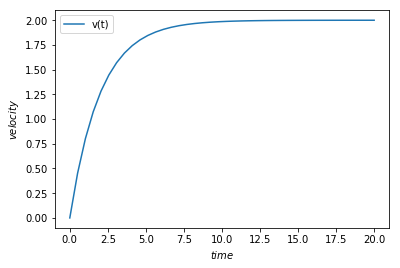

In [14]:
# Don't worry about the details of this code yet. 
def f_open_loop(x,t):
  v = x[0];
  kf = 0.5;
  u = 1;
  return [1 - kf*v]

x0=[0.0];
t = np.linspace(0., 20, 40)
x = spi.odeint(f_open_loop,x0,t);

plt.plot(t,x,label="v(t)");
plt.xlabel('$time$')
plt.ylabel('$velocity$')
plt.legend();

We denote the steady state value of a system's state with a subscript $ss$. So in this case, our steady state is denoted $v_{ss}$. We can solve for steady state by simply setting the rate of change of the state to zero. In this case, that means

> $\dot v = 0 = u - k_f v_{ss}$

or

> $v_{ss} = \frac{u}{k_f}.$

In the above plot, we used $u=1$ and $k_f = 0.5$ so $v_{ss} = 2 \; m/s$. 

Open Loop Control
===

In feedback control we define $u$ in terms of a sensor value and say we are *closing the loop*. If we define $u$ without using the sensors, we have no *feedback* and so our system is *open loop*. 

To define an open loop control, to control the velocity of this car we set the throttle, which defines the input $u$, to a fixed position and leave it there. We can calculate the required value of $u$ by setting $\dot v = 0$, assuming (i.e. hoping) $v_{ss} = v_{des}$ and solving for $u$:

> $u = k_f v_des$

Using this value for $u$ gives us the equation

> $\dot v = k_f v_{des} - k_f v.$

**Sensitivity to parameters**:: Certainly at steady state (i.e. when $\dot v = 0$) we have $v_{ss} = v_{des}$, so it would seem our controller works. However, our definition of $u$ depends on $k_f$, which is an estimate. Thus, the equation should really look like

> $\dot v = k_{f,est} v_{des} - k_{f,actual} v.$

In this case, at steady state, the velocity of the car will be 

> $v_{ss} = \frac{k_{f,est}}{k_{f,actual}} v_{des}$

and thus, even a 10% error in $k_f$ will result in a 10% error in $v_{ss}$. 

In the exercises below, you will see that with open loop control that $v_{ss}$ is also very sensitive to changes in the mass, $m$.

**Disturbances**: Suppose now that we are driving into a headwind. We can model the wind as an additive force. Suppose, for purposes of demonstration, that the wind hand magnitude $\varepsilon$. 

> $\dot v = u - k_f v - \varepsilon.$

In this case, our steady state becomes

> $v_{ss} = \frac{u - \varepsilon}{k_f} 
          = \frac{k_f v_{des} - \varepsilon}{k_f}
          = v_{des} - \frac{\varepsilon}{k_f}$
          
Thus, the steady state velocity depends on the force of headwind rather directly, which is not a great property for a cruise controller.

Proportional Feedback Control
===

The most obvious improvement on our control law is to use the value of the spedometer, that is $v$, to continuously adjusted the force applied to the car. *Negative feedback* uses the $error$ in the output to define $u$. We define the error as the difference between the desired state and the actual state:

> $e = v_{des} - v$

To define a *proportial feedback controller* we set

> $u = u_{ff} + K_p e$

where $u_{ff}$ is the feedforward value from the previous section and $K_p$ is an adjustable *gain$. Thus, we have

> $u = k_f v_{des} + K_p ( v_{des} - v ).$

You can see the reason this is called proportional control. The input provide to the system is proportional to the error. If we are going to slow, then $e>0$ and we apply a force proportional to $e$ in the positive direction. If we are going too fast, we do the opposite.

Putting in this value for $u$, we get the equation

> $\dot v = k_f v_{des} + K_p ( v_{des} - v ) - k_f v.$

Note that the *proportional gain* $K_p$ is something you as a control engineer get to choose. Below is a plot of the behavior of the system for different values of $K_p$.

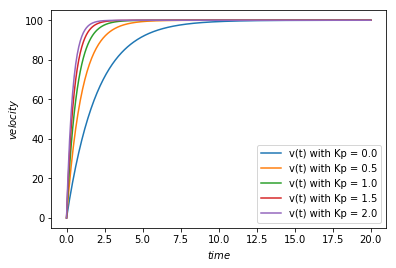

In [42]:
# Don't worry about the details of this code yet. 
def f_prop_kp(x,t,Kp):
  v = x[0];
  vdes = 100;
  kf = 0.5;
  u = kf * vdes + Kp*(vdes - v);
  return [u - kf * v]

x0=[0.0];
t = np.linspace(0., 20, 400)

for i in range(0,25,5):
    kp = i/10;
    f = lambda x,t : f_prop_kp(x,t,kp)
    x = spi.odeint(f,x0,t);
    plt.plot(t,x,label="v(t) with Kp = %r" % kp);

plt.xlabel('$time$')
plt.ylabel('$velocity$')
plt.legend();

As you can see, the system always settles down to the desired value for $v_{des}$ and the gain $K_p$ determines *how fast* the system settles down. 

**Sensitivity**: It would seem that our proportional controller works quite well. Let's look at how sensitive $v_{ss}$ is to our uncertainty in $k_f$. By distinguishing between the estimated and actual values of $k_f$ we get the equation

> $\dot v = k_{f,est} v_{des} + K_p ( v_{des} - v ) - k_{f,actual} v.$

Setting $\dot v = 0$ and $v_{ss} = v$ and solving for $v_{ss}$ gives

> $v_{ss} = \frac{k_{f,est} + K_p}{k_{f,actual} + K_p} v_{des}$

which looks pretty good! If we make $K_p$ much bigger than $k_f$, then $v_{ss} \approx v_{des}$ since the fractional term goes to $1$ as $K_f$ goes to infinity. 

To visualize this, suppose that $v_{des} = 100$, $k_{f,est} = \frac{1}{2} k_{f,actual}$ and $k_{f,actual} = 0.5$ and plot $v_{ss}$ as a function of $K_p$. 

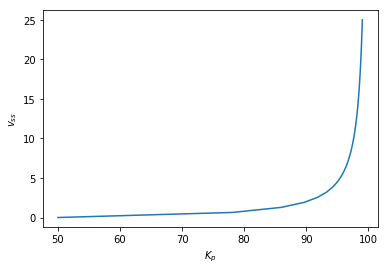

In [46]:
Kp = np.linspace(0., 25, 40)
plt.plot(100*(0.25+Kp)/(0.5+Kp),Kp);
plt.xlabel('$K_p$');
plt.ylabel('$v_{ss}$');

You can see that as you increase $K_p$ the *steady state error* $e_{ss}$ goes to zero and $v_{ss}$ goes to $v_{des}$. 

**Sensor Noise**: So we should just choose a really big gain, right? Wrong! For one thing, the bigger the gain, the harder the engine has to work to get to steady state and your passengers might become alarmed. More importantly, the problem is that we don't really have a perfect measurement of $v$. We might have a discretized value for $v$ coming from a microcontroller, their may be noise in the mechatronics that transmit the sensor value to the controller, and the sensor might have a delay, so that the value being sent to the controller is the value of the velocity at some (usually short) time in the past. So the proportional part of the controller actually 

> $K_p(v_{des} - v_{est})$

and if $v_{est}$ is noisy, then we will be amplifying that noise by $K_p$. So $K_p = 1000$ would be a very bad choise indeed. Thus, we have a **tradeoff**:

> Increasing $K_p$ decreases steady state error and settling time, but increases sensitivity to noise in our sensors.

This tradeoff is *always* the case in proportional control of a system using a sensor value.

Proportional-Integral Control
===

One intersting question is whether we can come up with a control law that is *insensitive* to undertainty in $k_f$ and even to disturbances such as wind. The answer is **yes**: Use an *integral term* and make a Proportional-Integral Controller, or PI Controller. 

A PI controller has an added *state*, usually denoted $z$, that is managed by the electronics (or whatever) that implement the control law. We define the rate of change of that state to be proportional to the error:

> $\dot z = K_I e = K_I (v_{des} - v)$

Where $K_I$ is called the *integral gain*, and is also something you choose as the control engineer. Notice that when $z$ stops changing so that $\dot z = 0$ it must be the case that $v_{des} = v$. Now we define the controller as

> $u = K_I z + K_P e \\
  \;\; = K_I z + K_P (v_{des} - v).$

and we end up with *two* equations that define how the system changes

> $\dot z = K_I (v_{des} - v) \\
   \dot v = K_I z + K_p ( v_{des} - v ) - k_f v.$